In [2]:
# !apt-get update && apt-get install libsm6 libxext6 -y -qq
# !apt-get install libgl1-mesa-glx graphviz -y -qq
# !pip install -r requirements.txt
# import os
# os._exit(0)
# # !apt-get install unrar

# IMPORT PACKAGES

In [11]:
import os
import shutil
import PIL
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import natsort
import sys
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

print(tf.__version__)
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
2.15.0
time: 16.6 ms (started: 2024-12-02 03:50:20 +00:00)


In [12]:
EPOCHS = 500
BATCH = 8
ETA = 0.001
WEIGHT_DECAY = 6e-8
IMAGE_SHAPE = (256, 512, 1)
MASK_SHAPE = (256, 512, 1)
model_path = './models'

time: 475 µs (started: 2024-12-02 03:50:21 +00:00)


In [13]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Enable GPU memory growth (optional)
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
    # Set mixed precision policy
    # policy = tf.keras.mixed_precision.Policy('mixed_float16')
    # tf.keras.mixed_precision.set_global_policy(policy)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow GPU device: ", tf.test.gpu_device_name())
print("All devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
TensorFlow GPU device:  /device:GPU:0
All devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 7.78 ms (started: 2024-12-02 03:50:22 +00:00)


2024-12-02 03:50:22.038029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 03:50:22.038685: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 03:50:22.038863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# READ DATASET (IMAGES, MASKS)

In [14]:
def load_image_and_mask(image_path, mask_path):
    # Load and decode the image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Grayscale mask
    # mask = tf.squeeze(mask, axis=-1)
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize to [0, 1]

    return image, mask

time: 656 µs (started: 2024-12-02 03:50:23 +00:00)


In [15]:
def create_dataset(image_dir, mask_dir, batch_size, is_training=True):
    image_paths = natsort.natsorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = natsort.natsorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda img, msk: load_image_and_mask(img, msk),
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.cache().shuffle(buffer_size=len(image_paths))

    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

time: 941 µs (started: 2024-12-02 03:50:24 +00:00)


In [16]:
train_dataset = create_dataset('./dataset/prepos_dataset/train/images', './dataset/prepos_dataset/train/masks', BATCH, is_training=True)
val_dataset = create_dataset('./dataset/prepos_dataset/val/images', './dataset/prepos_dataset/val/masks', BATCH, is_training=False)
test_dataset = create_dataset('./dataset/prepos_dataset/test/images', './dataset/prepos_dataset/test/masks', BATCH, is_training=False)

time: 221 ms (started: 2024-12-02 03:50:24 +00:00)


In [17]:
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

Image batch shape: (8, 256, 512, 1)
Mask batch shape: (8, 256, 512, 1)
time: 1.01 s (started: 2024-12-02 03:50:25 +00:00)


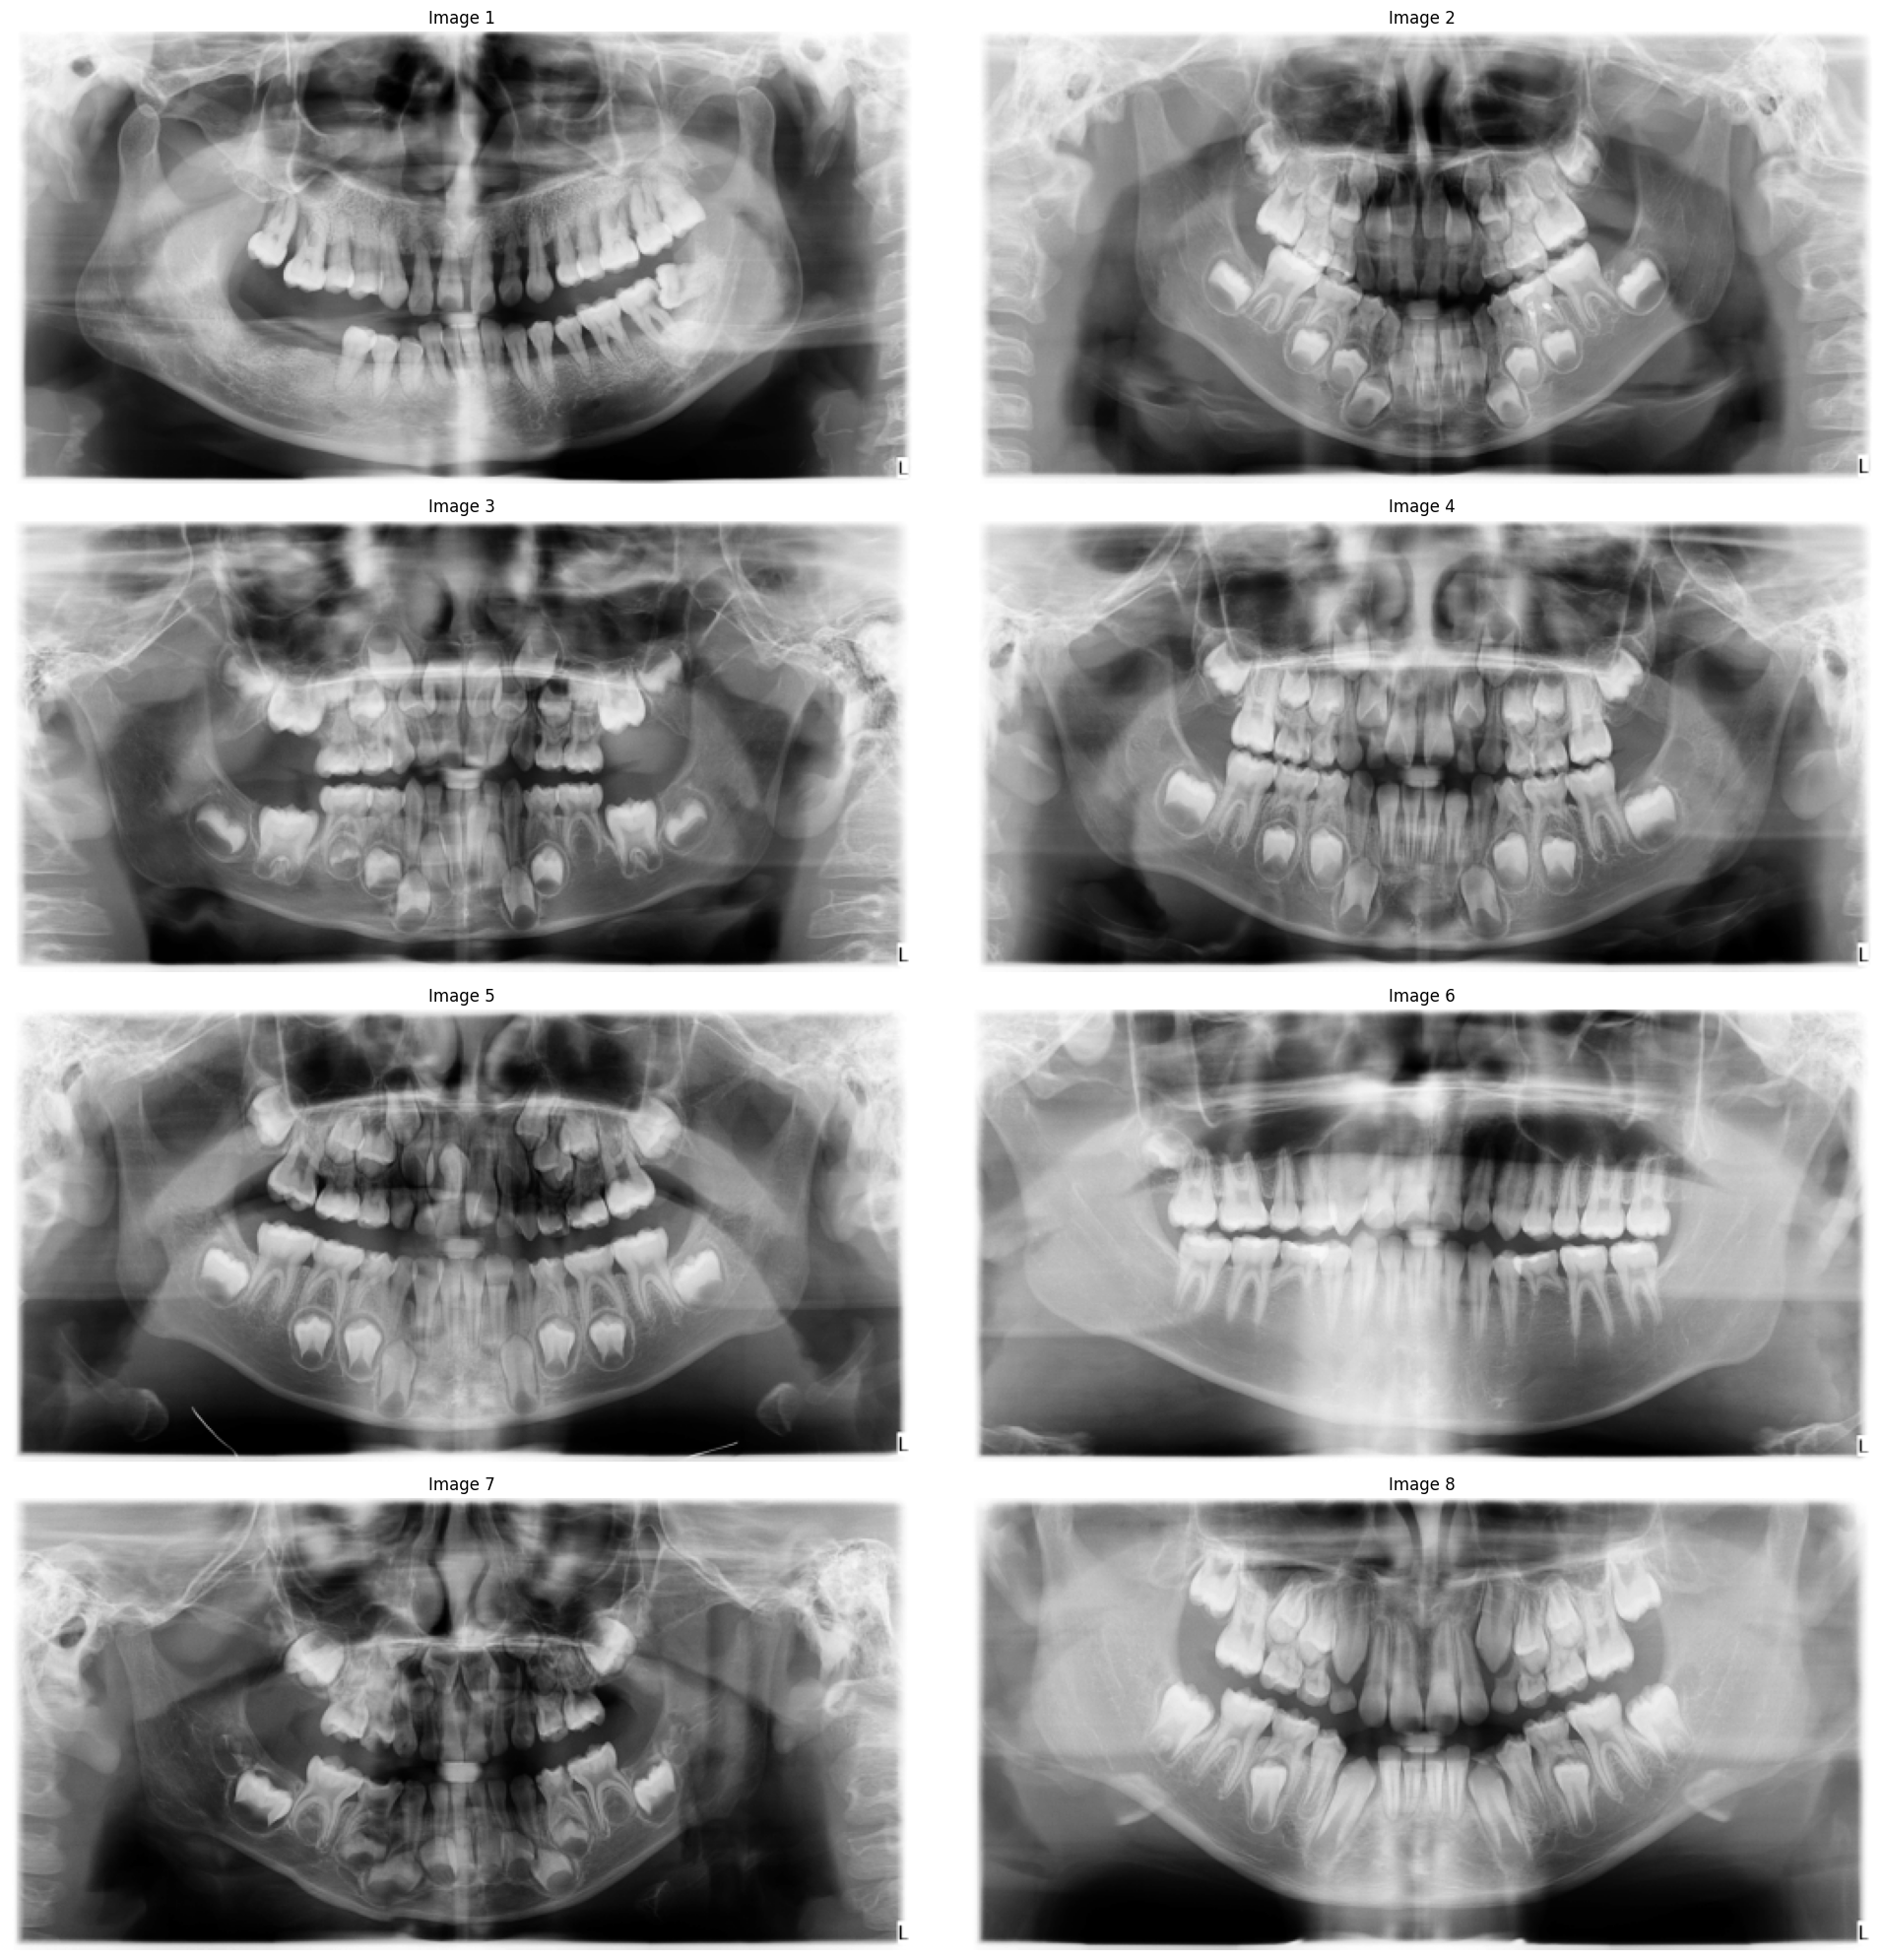

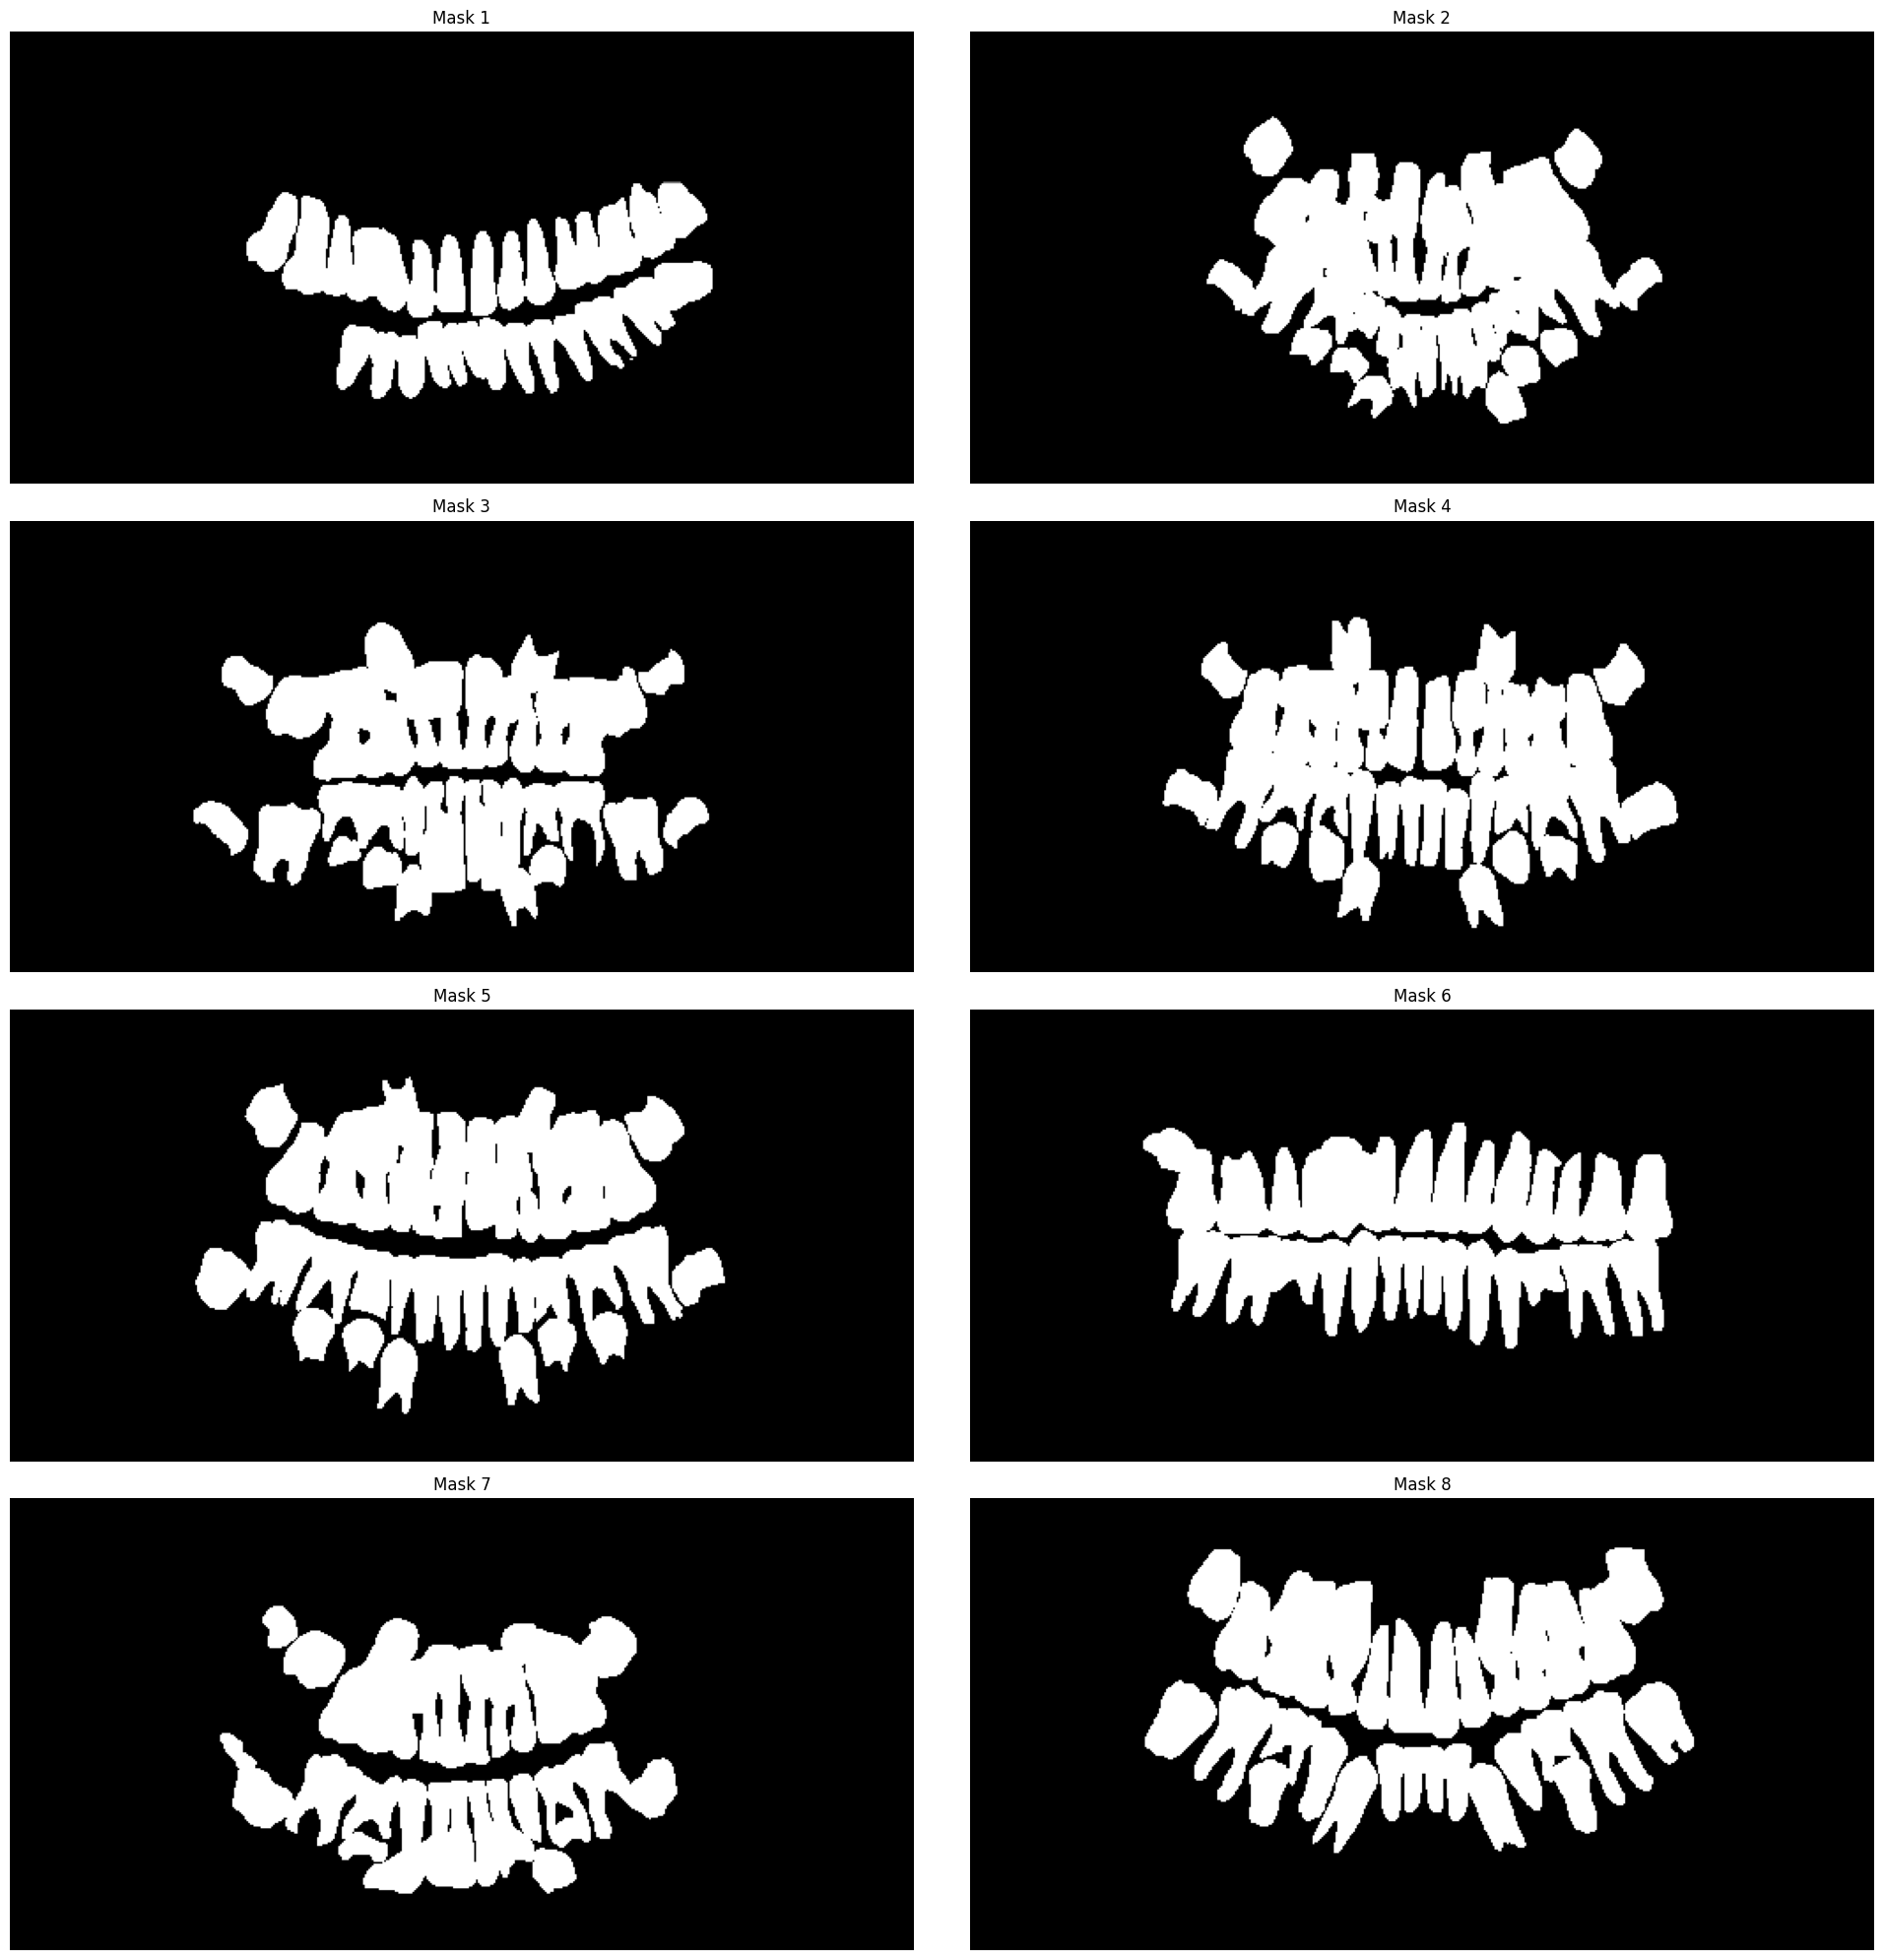

time: 2.54 s (started: 2024-12-02 03:50:26 +00:00)


In [18]:
def plot_dataset_batch(dataset, num_plots=None):
    # Get the first batch
    for images, masks in dataset.take(1):
        # Convert to NumPy
        images_np = images.numpy()
        masks_np = masks.numpy()
        
        # If num_plots is not specified, use batch size
        if num_plots is None:
            num_plots = images_np.shape[0]
        
        # Calculate grid dimensions
        cols = 2
        rows = math.ceil(num_plots / cols)
        
        plt.figure(figsize=(20, 5 * rows))
        
        for i in range(num_plots):
            plt.subplot(rows, cols, i+1)
            
            # Plot image
            plt.imshow(images_np[i],  cmap='gray')
            plt.title(f'Image {i+1}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Mask plot
        plt.figure(figsize=(20, 5 * rows))
        
        for i in range(num_plots):
            plt.subplot(rows, cols, i+1)
            
            # Plot mask (squeeze to remove extra dimensions)
            plt.imshow(masks_np[i].squeeze(), cmap='gray')
            plt.title(f'Mask {i+1}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Break after first batch
        break

plot_dataset_batch(val_dataset)

# Define Dice Loss

In [10]:
def dice_score(y_true, y_pred, threshold=0.5):
    smooth = 1.
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred >= threshold, [-1]), dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1. - dice_score(y_true, y_pred)
    return tf.cast(loss, dtype=tf.float32)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def bfce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryFocalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def binaryIoU_loss(y_true, y_pred):
    IoU =  tf.keras.metrics.BinaryIoU()(y_true, y_pred)
    return 1 - IoU

time: 1.03 ms (started: 2024-12-01 09:24:33 +00:00)


# Proposing a generative neural network architecture

In [11]:
def convolution(input, filter, padding, strides, kernel, activation, conv_type, name_prefix=''):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = input
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                      kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv1')(x)
    x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn1')(x)
    
    if conv_type == 'decoder':
        x = layers.Activation(activation, name=f'{name_prefix}_activation1')(x)
        x = layers.Conv2D(filter*2, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv2')(x)
        x = layers.GroupNormalization(groups=filter*2, name=f'{name_prefix}_gn2')(x)
        x = layers.Activation(activation, name=f'{name_prefix}_activation2')(x)
        x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv3')(x)
        x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn3')(x)
    
    x = layers.average([x, layers.Conv2D(filter, kernel_size=1, padding='same', strides=1, kernel_initializer=initializer, name=f'{name_prefix}_conv4')(input)], name=f'{name_prefix}_residual_connection')
    x = layers.Activation(activation, name=f'{name_prefix}_rescon_activation')(x)
    return x

time: 1.95 ms (started: 2024-12-01 09:24:33 +00:00)


In [12]:
def encoder(input, filter, padding, strides, kernel, activation, name_prefix):
    x = input
    x = convolution(x, filter, padding, strides, kernel, activation, 'encoder', name_prefix=name_prefix)
    downsample = layers.AveragePooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return downsample, x

time: 537 µs (started: 2024-12-01 09:24:33 +00:00)


In [13]:
def decoder(input, filter, skip, padding, strides, kernel, activation, name_prefix, dropout=False):
    x = input
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2DTranspose(filter, padding = padding, kernel_size = kernel,
                               activation=activation, strides = 2, kernel_initializer=initializer,
                               use_bias=False, name=f'{name_prefix}_transpose')(x)
    
    if dropout:
        x = layers.Dropout(0.5, name=f'{name_prefix}_dropout')(x)
    x = layers.average([x, skip], name=f'{name_prefix}_skip_connection')
    x = convolution(x, filter, padding, strides, kernel, activation, 'decoder', name_prefix=name_prefix)
    return x

time: 544 µs (started: 2024-12-01 09:24:33 +00:00)


In [14]:
def bottleneck(input, filters_bottleneck, strides, kernel, activation, depth=6, mode='cascade', name_prefix=''):
    dilated_layers = []
    x = input
    if mode == 'cascade':
        for i in range(depth):
            residual = x
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02), name=f'{name_prefix}_conv_{i+1}')(x)
            dilated_layers.append(x)
        x = layers.add(dilated_layers, name=f'{name_prefix}_dilated_layers')
        x = layers.GroupNormalization(groups=filters_bottleneck, name=f'{name_prefix}_gn')(x)
        return x
    
    elif mode == 'cascade_residual':
        for i in range(depth):
            residual = x  # Save the input for the residual connection
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                              activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            if i % 2 == 0:  # Add residual connection only on even convolutional layers
                # Add a 1x1 convolution to the residual connection to match shapes
                residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                         padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
                residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
                # Add the residual connection
                x = layers.add([x, residual])
            
        cascade_layer = layers.add(dilated_layers)
        fusion = layers.add([cascade_layer, x])
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'cascade_residual_multidimension':
        for i in range(depth):
            residual = x 
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                     padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
            residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
            x = layers.add([x, residual])
            dilated_layers.append(x)
        fusion = layers.add(dilated_layers)
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                layers.Conv2D(filters_bottleneck, kernel_size=kernel,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            )
        parallel = layers.add(dilated_layers) 
        parallel = layers.GroupNormalization(groups=filters_bottleneck)(parallel)
        return parallel

time: 2.08 ms (started: 2024-12-01 09:24:33 +00:00)


In [15]:
def generator(input, filter, padding, strides, kernel, model_weights, weights_path=''):
    x = input
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder4')
    deco1 = decoder(con4, filter*8, skip4, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder1')
    deco2 = decoder(deco1, filter*4, skip3, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder2')
    deco3 = decoder(deco2, filter*2, skip2, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder3')
    deco4 = decoder(deco3, filter, skip1, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder4')
    
    initializer = tf.random_normal_initializer(0., 0.02)
    output = layers.Conv2DTranspose(1, kernel_size=kernel, strides=strides, padding=padding, 
                                    kernel_initializer=initializer, activation='sigmoid', 
                                    name='generator_output_layer')(deco4)
    
    generator = models.Model(inputs=input, outputs=output, name='generator')
    
    if model_weights is not None:
        generator.load_weights(weights_path)
    generator.summary()
    return generator

time: 1.49 ms (started: 2024-12-01 09:24:33 +00:00)


In [16]:
generator = generator(input=layers.Input(shape = IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                            model_weights=None, 
                            weights_path="")

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 256, 512, 32)         288       ['input_1[0][0]']             
                                                                                                  
 encoder1_gn1 (GroupNormali  (None, 256, 512, 32)         64        ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_conv4 (Conv2D)     (None, 256, 512, 32)         64        ['input_1[0][0]']     

In [17]:
# tf.keras.utils.plot_model(generator, show_shapes = True, show_layer_names=True, to_file='./chart/generator.png')

time: 167 µs (started: 2024-12-01 09:24:34 +00:00)


In [18]:
def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, lossFn, learning_rate, weight_decay, model_weights, weights_path=''):
    x = layers.multiply([ImageInput, maskInput])
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder4')
    x = layers.GlobalAveragePooling2D()(con4)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    discriminator = models.Model(inputs=[maskInput, ImageInput], outputs=x, name='discriminator')
    if model_weights is not None:
        discriminator.load_weights(weights_path)
    discriminator.compile(loss=lossFn, loss_weights=[1],
                          optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=weight_decay),)
    discriminator.summary()
    return discriminator

time: 772 µs (started: 2024-12-01 09:24:34 +00:00)


In [19]:
discriminator = discriminator(ImageInput=layers.Input(shape=IMAGE_SHAPE), 
                                    maskInput=layers.Input(shape=MASK_SHAPE),
                                    filter=32, padding = 'same', strides=1, kernel=3, 
                                    lossFn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                    learning_rate=ETA, weight_decay=WEIGHT_DECAY,
                                    model_weights=None,
                                    weights_path="")

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 multiply (Multiply)         (None, 256, 512, 1)          0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 disc_encoder1_conv1 (Conv2  (None, 256, 512, 32)         288       ['multiply[0][0]']

In [20]:
# tf.keras.utils.plot_model(discriminator, show_shapes = True, show_layer_names=True, to_file='./chart/discriminator.png')

time: 222 µs (started: 2024-12-01 09:24:34 +00:00)


In [21]:
def GAN(discriminator, generator, learning_rate, weight_decay, lossFn):
    imageInput=layers.Input(shape=IMAGE_SHAPE, name="image_Input")
    maskInput=layers.Input(shape=MASK_SHAPE, name="mask_Input")
    
    discriminator.trainable = False
    
    fakeMasks = generator(imageInput)
    discriminatorInput = discriminator([fakeMasks, imageInput])
    
    gan = models.Model(inputs=[maskInput, imageInput],
                       outputs=[discriminatorInput, fakeMasks],
                       name='cgan')
    
    gan.compile(loss=lossFn, loss_weights=[1,100], 
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate*0.5, weight_decay=weight_decay*0.5),
                metrics=tf.keras.losses.BinaryCrossentropy(from_logits=True))
    gan.summary()
    return gan

time: 1.14 ms (started: 2024-12-01 09:24:34 +00:00)


In [22]:
gan = GAN(discriminator=discriminator, generator=generator,
          learning_rate=ETA, weight_decay=WEIGHT_DECAY, 
          lossFn=[tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 'mae'])

# Notes the loss functions is (log BCE + MAE * 100(lambda))
# Following the isola et al loss functions 

Model: "cgan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_Input (InputLayer)    [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 256, 512, 1)          5417185   ['image_Input[0][0]']         
                                                                                                  
 mask_Input (InputLayer)     [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 discriminator (Functional)  (None, 1)                    432097    ['generator[0][0]',           
                                                                     'image_Input[0][0]']      

In [23]:
# tf.keras.utils.plot_model(gan, show_shapes = True, show_layer_names=True, to_file='./chart/gan.png')

time: 202 µs (started: 2024-12-01 09:24:35 +00:00)


In [24]:
def samples(generator, images, realMasks):
    predMasks =  tf.squeeze(generator(images, training=False))
    plt.figure(figsize=(12,6))
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.title('Input Image')
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.title('Ground Truth')
        plt.imshow(realMasks[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.title('Predicted Mask')
        plt.imshow(predMasks[i], cmap='gray')
        plt.axis('off')
    plt.show()

time: 1.18 ms (started: 2024-12-01 09:24:35 +00:00)


2024-12-01 09:24:37.879044: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-01 09:24:55.927506: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdc440bd150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-01 09:24:55.927542: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-01 09:24:55.931888: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733045095.990306   98711 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus

Epoch/Epochs: 0/500
discriminator loss: [tag: 0.6677842140197754], generator loss: [tag: [1.0968371629714966, 0.6874586343765259, 0.0040937853045761585, 0.6874586343765259, 0.05288921669125557]]


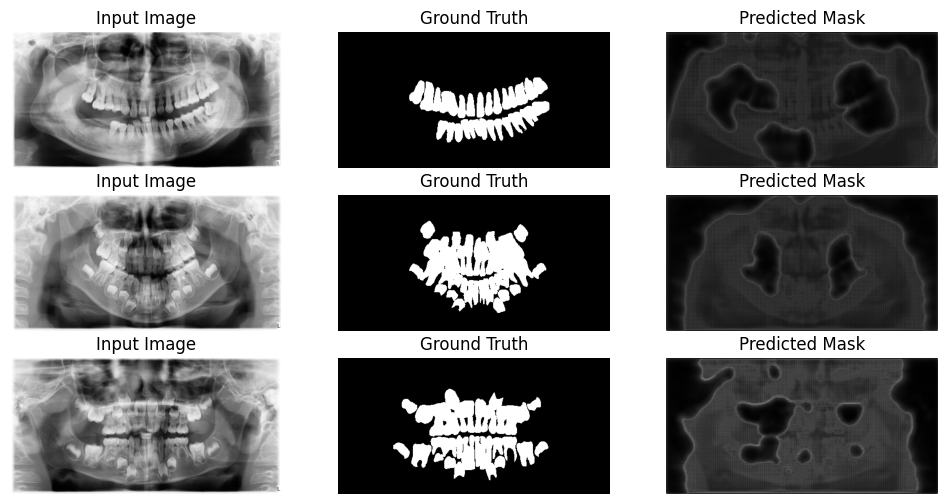

2024-12-01 09:52:18.442693: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB (rounded to 134217728)requested by op gradient_tape/cgan/discriminator/disc_encoder1_pool/AvgPoolGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-12-01 09:52:18.442855: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-12-01 09:52:18.442879: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 167, Chunks in use: 162. 41.8KiB allocated for chunks. 40.5KiB in use in bin. 12.0KiB client-requested in use in bin.
2024-12-01 09:52:18.442894: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 36, Chunks in use: 30. 19.5KiB allocated for chunks. 15.8KiB in use in bin. 15

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/cgan/discriminator/disc_encoder1_pool/AvgPoolGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_98661/805359152.py", line 17, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2787, in train_on_batch

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[8,32,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/cgan/discriminator/disc_encoder1_pool/AvgPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_24073]

time: 27min 43s (started: 2024-12-01 09:24:35 +00:00)


In [25]:
dlossTagList = []
glossTagList = []
tf.keras.backend.clear_session()
for epoch in range(EPOCHS):
    for batch in train_dataset:
        realImages, realMasks = batch
        realTag = tf.ones(shape = (BATCH, ))

        fakeMasks = generator(realImages, training=False) 
        fakeTag = tf.zeros(shape = (BATCH, ))

        allMasks = tf.concat([realMasks, fakeMasks], axis=0)
        allImages = tf.concat([realImages, realImages], axis=0) 
        allTags = tf.concat([realTag, fakeTag], axis=0)

        dlossTag = discriminator.train_on_batch([allMasks, allImages], [allTags])
        glossTag = gan.train_on_batch([realMasks, realImages], [realTag, realMasks])

        dlossTagList.append(dlossTag)
        glossTagList.append(glossTag) 
    if epoch % 50 == 0:
        print(f"Epoch/Epochs: {epoch}/{EPOCHS}")
        print(f"discriminator loss: [tag: {dlossTag}], generator loss: [tag: {glossTag}]")
        valImages, valMasks = next(iter(val_dataset))
        samples(generator, valImages[:3], valMasks[:3])
    elif epoch == EPOCHS-1:
        print(f"Epoch/Epochs: {epoch}/{EPOCHS}")
        print(f"discriminator loss: [tag: {dlossTag}], generator loss: [tag: {glossTag}]")
        valImages, valMasks = next(iter(val_dataset))
        samples(generator, valImages[:3], valMasks[:3])

In [ ]:
df = pd.DataFrame(glossTagList, columns=["loss 1", "loss 2", "loss 3", "loss 4", "loss 5"])
df['loss 1'] = df['loss 1'] - df['loss 5']
print(f"min mae index-: {df['loss 1'].idxmin()}")
print(f"min mae: {round(np.min(df['loss 1']),4)}")
print(f"last mae: {round(df['loss 1'].iloc[-1],4)}")

plt.figure(figsize=(12, 6))
plt.plot(dlossTagList, label='Discriminator Loss (Tag)')
plt.plot(df['loss 5'], label='Generator Loss (Tag)')
plt.plot(df['loss 1'], label='L1 Loss (mae)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()
plt.savefig('/notebooks/chart/first_loss_chart.png')

In [ ]:
generator_saved = f'4block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_generator.h5'
discriminator_saved = f'4block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_discriminator.h5'

generator_path = os.path.join(model_path, generator_saved)
discriminator_path = os.path.join(model_path, discriminator_saved)

generator.save_weights(generator_path)
discriminator.save_weights(discriminator_path)

- Now we will train the generator again with a number of layers frozen in order to maintain the capacity that the generator has gained.

In [ ]:
weight_path = generator_path

generator2 = generator(input=layers.Input(shape=IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                             model_weights=True, weights_path=weight_path)

for layer in generator2.layers[:20]:
    layer.trainable = False
    
optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-7)
generator2.compile(loss=bce_dice_loss,
                         optimizer=optimizer, 
                         metrics=[tf.keras.metrics.Precision(name = 'precision'),
                                  tf.keras.metrics.Recall(name = 'recall'), 
                                  tf.keras.metrics.BinaryIoU(name = 'IoU'),
                                  dice_score])

# Evaluate the generator model

In [ ]:
generator2.evaluate(validImages, validMasks)

In [ ]:
generator2.evaluate(testImages, testMasks)

In [ ]:
def draw(images, masks, y_pred):
    plt.figure(figsize = (12, 24))
    index = -1
    n = np.random.randint(y_pred.shape[0])
    for i in range(120):
        plt.subplot(20, 6, (i + 1))
        if index == -1:
            plt.imshow(images[n], cmap = 'gray')
            plt.title('Image')
            plt.axis('off')
            index = 0
        elif index == 0:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
            plt.title('Original Mask')
            plt.axis('off')
            index = 1
        elif index == 1:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(np.reshape(y_pred[n], IMAGE_SHAPE[:2]), alpha = 0.6, cmap = 'gray')
            plt.title('Predict Mask')
            plt.axis('off')
            index = -1
            n = np.random.randint(y_pred.shape[0])
    plt.legend()

In [ ]:
masks_pred = generator2.predict(validImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
masks_pred.shape
draw(validImages, validMasks, masks_pred)

# Re-training of the generator according to the pixel2pixel methodology

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,           # Reduce the learning rate by a factor of 0.2
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    mode='min',
    min_delta=1e-4,       # minimum changed in monitor metrics
)

history = generator2.fit(trainImages, trainMasks, epochs=200, batch_size=8,
                               validation_data=(validImages, validMasks), verbose=2, 
                               callbacks=[early_stopping, reduce_lr])

# The results obtained

In [ ]:
metrics = ['loss', 'precision', 'recall', 'IoU', 'dice_score']
plt.figure(figsize = (15, 9))
for i in range(5):
    plt.subplot(2, 3, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.legend()
plt.savefig('/notebooks/chart/secondtrain_history_chart_1.png')

In [ ]:
metrics = ['precision', 'recall', 'IoU', 'dice_score']
plt.figure(figsize = (12, 8))
for i in range(4):
    plt.subplot(2, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.legend()
plt.savefig('/notebooks/chart/secondtrain_history_chart_2.png')

In [ ]:
generator2.evaluate(validImages, validMasks)

In [ ]:
generator2.evaluate(testImages, testMasks)

In [ ]:
generator_path2 = os.path.join(model_path, 'final', f'final_{generator_saved}')
generator2.save(generator_path2)

In [ ]:
generator3 = tf.keras.models.load_model(generator_path2,  
                                        custom_objects={'bce_dice_loss':bce_dice_loss,
                                                        'dice_score': dice_score})

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predIdxs = generator3.predict(validImages)
predIdxs = (predIdxs >= 0.5).astype('int')

validMasks_flat = validMasks.flatten()
predIdxs_flat = predIdxs.flatten()

print("validMasks shape:", validMasks_flat.shape)
print("predIdxs shape:", predIdxs_flat.shape)

class_names = ["Object", "Background"]

print(classification_report(
    validMasks_flat, predIdxs_flat,
    target_names=class_names
))

conf_mat = confusion_matrix(validMasks_flat, predIdxs_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('/notebooks/chart/secondtrain_confusion_matrix.png')

In [ ]:
masks_pred = generator3.predict(validImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(validImages, validMasks, masks_pred)

In [ ]:
masks_pred = generator3.predict(testImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(testImages, testMasks, masks_pred)

In [ ]:
masks_pred = generator3.predict(trainImages, verbose=0)
masks_pred = (masks_pred >= 0.5).astype('int')
print(masks_pred.shape)
draw(trainImages, trainMasks, masks_pred)

In [ ]:
import zipfile,os
folder_to_zip = os.path.join(os.getcwd(),'chart')
zip_file_name =  os.path.splitext(generator_saved)[0].replace("_generator", "") + '.zip'
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for foldername, subfolders, filenames in os.walk(folder_to_zip):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, folder_to_zip)
            zipf.write(file_path, arcname)
zipf.close()

print(f"{zip_file_name} success zipping...")